# MPB field profiles

Setup as before :

In [73]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

In [74]:
# Parameters for the waveguide
w = 0.3  # Si width (um)
h = 0.25  # Si height (um)

# Materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

sc_y = 2  # supercell width (um)
sc_z = 2  # supercell height (um)
resolution = 32  # pixels/um
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# define the 2d blocks for the strip and substrate
geometry = [mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5 * (sc_z - h)),
                     center=mp.Vector3(z=0.25 * (sc_z + h)), material=SiO2),
            mp.Block(size=mp.Vector3(mp.inf, w, h), material=Si)]

# The k (i.e. beta, i.e. propagation constant) points to look at, in
# units of 2*pi/um.  We'll look at num_k points from k_min to k_max.
num_k = 30
k_min = 0.1
k_max = 3.0
k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])

# Increase this to see more modes.  (The guided ones are the ones below the
# light line, i.e. those with frequencies < kmag / 1.45, where kmag
# is the corresponding column in the output if you grep for "freqs:".)
num_bands = 4

# ModeSolver object
ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    # Add new things pertaining to simulation
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands,
    filename_prefix='strip_wvg_fields_'
    )

We know how the bands look like, so let's now look at the modes at a given frequency, say $1.55\mu$m. We can proceed inversely : `ms.run()` computes $\omega(k)$, while `ms.find_k` computes $k(\omega)$. Here, we will also pass a mpb.output function to the `run()` function, which will output h5 files. This is useful when what is being output is not a single number like before.

In [75]:
f_mode = 1/1.55   # frequency corresponding to 1.55 um                                                                                                             
band_min = 1
band_max = 1 # Look at the two lowest modes
kdir = mp.Vector3(1)
tol = 1e-6
kmag_guess = f_mode*3.45
kmag_min = f_mode*0.1
kmag_max = f_mode*4.0

ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max, mpb.output_poynting_x)

Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 64 x 64.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0.5625)
          size (1e+20,1e+20,0.875)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1e+20,0.3,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<2.2258064516129035, 0.0, 0.0>
elapsed time for initialization: 0.01967787742614746
solve_kpoint (2.22581,0,0):
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 26 it

[1.035845017511875]

## Reading the fields

http://docs.h5py.org/en/stable/quick.html

In [76]:
import h5py
f = h5py.File('strip_wvg_fields_-flux.v.k01.b01.x.h5', 'r')

In [77]:
list(f.keys())

['Bloch wavevector', 'description', 'lattice vectors', 'x.i', 'x.r']

In [78]:
f['description'][()]

b'v field, kpoint 1, band 1, freq=0.645161'

In [79]:
f['x.r'].shape

(64, 64)

In [80]:
field1 = np.power(f['x.r'], 2) + np.power(f['x.i'], 2)

epsilon: 1-11.9025, mean 1.68727, harm. mean 1.33783, 47.4609% > 1, 6.30378% "fill"


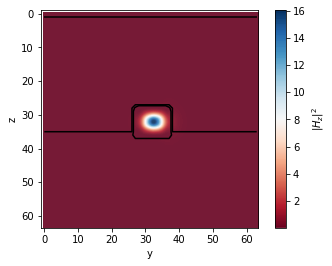

In [83]:
n = np.sqrt(ms.get_epsilon())

fig, ax = plt.subplots(figsize=(6, 4))

pos = ax.imshow(field1, cmap='gray_r', interpolation='spline36', extent=[-sc_y/2,sc_y/2,-sc_z/2,sc_z/2] )
pos = ax.imshow(field1, cmap='RdBu', interpolation='spline36', alpha=0.9)
ax.contour(n.T, [1,1.45,3.45], colors='k')
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('$|H_z|^2$')
ax.set_xlabel('y')
ax.set_ylabel('z')
plt.show()